Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.

Импортируем необходимые для работы библиотеки

In [1]:
!pip install -q torchvision sentence_transformers tf-keras keras_nlp

In [2]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import math
from math import ceil
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import transforms
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import random
import transformers 
import requests
import torch
import torch.nn as nn
#import torch.nn.functional as F
import torchvision.models as models

from pathlib import Path
import pickle
from PIL import Image

from collections import Counter

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Reshape, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow import keras
from keras import layers
#from keras import backend as K
import keras_nlp

import re
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

import os
from tqdm import notebook

from catboost import CatBoostRegressor

from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

import sentence_transformers
from sentence_transformers import SentenceTransformer, util
import glob
from tqdm.notebook import tqdm
tqdm.pandas()
nltk.download('averaged_perceptron_tagger')

# настраиваем отображение
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gusachenkomaria/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gusachenkomaria/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/gusachenkomaria/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/gusachenkomaria/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/gusachenkomaria/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/gusachenkomaria/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
# задаем константы 
PATH = '/Users/gusachenkomaria/Downloads/to_upload/'#'../Downloads/to_upload/'#/Users/gusachenkomaria/Downloads/to_upload
TRAIN_IMAGES_PATH = '/Users/gusachenkomaria/Downloads/to_upload/train_images'
TEST_IMAGES_PATH= '/Users/gusachenkomaria/Downloads/to_upload/test_images'
RANDOM_STATE = 12345
BATCH_SIZE=100
IMG_SHAPE=(224, 224, 3)

np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
# torch.use_deterministic_algorithms(True)

# настраиваем производительность
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu");

Напишем функции, которыми воспользуемся в проекте

In [4]:
# загружаем данные и читаем файлы
def read_df(path) -> pd.DataFrame:

    '''читаем датафреймы из указанного источника'''
    
    df_train = pd.read_csv(path + 'train_dataset.csv')
    df_crowd = pd.read_csv(path + 'CrowdAnnotations.tsv', sep='\t',
                           names=['image', 'query_id', 'share_pos', 'count_pos', 'count_neg'])
    df_expert = pd.read_csv(path + 'ExpertAnnotations.tsv', sep='\t',
                           names=['image', 'query_id', 'first', 'second', 'third'])
    df_queries = pd.read_csv(path + 'test_queries.csv', index_col=[0], sep='|')
    df_images = pd.read_csv(path + 'test_images.csv', sep='|')
    
    return df_train, df_crowd, df_expert, df_queries, df_images

In [5]:
#Функция нахождения основной информации о таблице
def explore_dataframe(df):
    print("Shape of dataframe:", df.shape)
    display(df.head())
    print("Info of dataframe: \n")
    df.info()
    print("Summary statistics of dataframe: \n", df.describe())
    print("Missing values in dataframe: \n", df.isnull().sum())
    print("Duplicate rows in dataframe:", df.duplicated().sum())

In [6]:
stops = set(stopwords.words('english'))
def most_common_words(text):
    count = Counter()
    for line in text:
        line = re.sub('[^a-zA-Z]', ' ', line).lower()
        words = [w for w in line.split(" ") if w not in (stops)]
        count.update(words)
    return count.most_common(10)

In [7]:
# выводим график 10 самых распространенных слов в описаниях
def most_common_words_show(mcw):
    fig, ax = plt.subplots(figsize=(10,5))
    (most_common_words[mcw['word'] != '']
                   .plot(kind='bar', 
                    x='word', 
                    y='count',
                    ax=ax,
                    rot=0,
                    title='Наиболее популярные слова'))

    ax.set_xlabel('Наиболее популярные слова')
    ax.set_ylabel('Количество упоминаний')
    plt.show();

In [8]:
#функция голосования большинством 
def voting(v1, v2, v3):
    if v1 == v2 or v1 == v3:
        return v1
    elif v2 == v3:
        return v2
    else:
        return None

In [9]:
# агрегируем оценки людей и экспертов
def score_aggregate(row) -> object:

    if np.isnan(row['expert_score']):
        row['score'] = row['share_pos']
    elif np.isnan(row['share_pos']):
        row['score'] = row['expert_score']
    else:
        row['score'] = row['expert_score'] * 0.7 + row['share_pos'] * 0.3
        
    return row

In [10]:
# функция лемматизации и очистки текста
def lemmatize_text(text):    
    text = text.lower() 
    text = re.sub('[^a-zA-Z]', ' ', text) 
    text = nltk.word_tokenize(text, language = 'english') 
    text = [lemmatizer.lemmatize(word) for word in text] 
    
    return text

In [11]:
# создаем функцию пометки описаний для блокирования
def block(row) -> object:
    
    text = row['lemm_query']
    
    if [i for i in text if i in BLOCK]:
        row['to_block'] = 1
    else:
        row['to_block'] = 0

    return row

In [12]:
# Создадим свёрточную нейросеть, она позволит извлечь главные компоненты изображений

def create_model():
    # Загружаем предварительно обученную модель ResNet50 без верхних слоев и весов ImageNet
    backbone = ResNet50(input_shape=(224, 224, 3),
                        include_top=False,
                        weights='imagenet')

    model = Sequential()
    # Добавляем загруженную модель как основу
    model.add(backbone)
    # Добавляем слой GlobalAveragePooling2D для усреднения признаков по пространству
    model.add(GlobalAveragePooling2D())
    # Компилируем модель, используя среднеквадратичную ошибку как функцию потерь и оптимизатор Adam с низкой скоростью обучения
    optimizer = Adam(learning_rate=0.0001)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

    return model

In [13]:
def image_vectorization(model, train_data):

    predictions = model.predict(train_data)
    return predictions

In [14]:
def vectorization_text(text):
    # векторизируем текст
    embeddings = []
    for i in tqdm(range(padded.shape[0] // BATCH_SIZE +1)):
        N = (i+1) * BATCH_SIZE
        if(i == padded.shape[0] // BATCH_SIZE):
            N = padded.shape[0]
        batch = torch.LongTensor(padded[BATCH_SIZE*i:N])
        attention_mask_batch = torch.LongTensor(attention_mask[BATCH_SIZE*i:BATCH_SIZE*(i+1)])

        with torch.no_grad():
            batch_embeddings = bert(batch, attention_mask=attention_mask_batch)

        embeddings.append(batch_embeddings[0][:,0,:].numpy())
    
    return np.concatenate(embeddings)

In [15]:
#функция обучения моделей
def study_model(model, param_dist, X_t, y_t):
    rs = RandomizedSearchCV(model, 
                        param_dist, 
                        n_iter = 10, 
                        scoring = 'neg_root_mean_squared_error',
                        cv=5,
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=RANDOM_STATE)
    rs.fit(X_t, y_t)

    model = rs.best_estimator_
    model.params = rs.best_params_
    result = rs.best_score_
    return model, model.params, result

In [16]:
#Функция инициализации сети
def net_init(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_out_neurons, p_dropout):
    torch.manual_seed(RANDOM_STATE)
    
    net = nn.Sequential(
        nn.Linear(n_in_neurons, n_hidden_neurons_1),
        nn.Dropout(p=p_dropout),
        nn.ReLU(),
        nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
        nn.Dropout(p=p_dropout),
        nn.ReLU(),
        nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3),
        nn.Dropout(p=p_dropout),
        nn.ReLU(),
        nn.Linear(n_hidden_neurons_3, n_out_neurons)
    )
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    loss = nn.MSELoss()
    return net, optimizer, loss

In [17]:
def new_net_training(num_epochs, batch_size):
         
#batch_size = 40

#num_epochs = 10000
    best_rmse = 20000

    num_batches = ceil(len(X_train)/batch_size)

# Создаем цикл обучения и предсказания нейросети
    for epoch in range(num_epochs):
        order = np.random.permutation(len(X_train))
    # Подбор весов на тренировочной выборке
        for batch_idx in range(num_batches):
            start_index = batch_idx * batch_size
            optimizer.zero_grad()

            batch_indexes = order[start_index:start_index+batch_size]
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]

            preds = model.forward(X_batch).flatten()
#
            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()

    
    # Предсказания на тестовой выборке
        if epoch % 5 == 0 or epoch == num_epochs - 1:
            model.eval()
            test_preds = model.forward(X_val)
            rmse = mean_squared_error(y_val, test_preds.detach().numpy(), squared=False)
            if rmse < best_rmse:
                best_rmse = rmse
                best_preds = test_preds
                best_model = model
            #print(f'Эпоха № {epoch} завершилась с метрикой RMSE = {rmse}')
    print('Лучшая метрика RMSE равна', best_rmse)
    return best_preds, best_rmse, best_model

In [18]:
def check(text):
    # проверяем, не нужно ли вывести на экран заглушку
    if [i for i in lemmatize_text(text) if i in BLOCK]: 
        #print('')
        print('-' * 10, text, '-' * 10)
        print('')
        print('This image is unavailable in your country in compliance with local laws.')
        print('')
    else:
        text_emb = vectorization_text(text)        
        # объединяем векторы тестовых картинок с эмбеддингом текста
        X = np.concatenate(( 
            image_embeddings_test,
            np.resize(text_emb, (image_embeddings_test.shape[0],768))),
            axis=1)
        X = scaler.transform(X)
        
        # создаем тензор для обучения нейросети
        X = torch.FloatTensor(X)
        # получаем предсказания экпертных оценок      
        with torch.no_grad():
            predictions = model.forward(X).flatten() 
             
        # добавляем оценки к номерам изображений
        df = pd.concat((df_images, 
                        pd.Series(np.reshape(predictions, (predictions.shape[0],)), name='pred')), axis=1) 
        
        
        print('')
        print('-' * 20, text, '-' * 20)
        print('')
        
        
        # если текст был в исходном файле с описаниями - добавляем оригинальное изображение
        if text in list(df_queries['query_text']): 
            #plt.rcParams['axes.edgecolor'] = 'green'
            #plt.rcParams['axes.linewidth'] = 5
            #fig.add_subplot(1, 6, 6)
            image = Image.open(TEST_IMAGES_PATH+'/'\
                               +df_queries.iloc[df_queries[df_queries['query_text'] == text].index[0]]['image'])
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
        
        plt.show()

Загрузим датасеты и проведем исследовательский анализ каждого в отдельности

In [19]:
df_train, df_crowd, df_expert, df_queries, df_images = read_df(PATH)

### df_train

In [20]:
explore_dataframe(df_train)

Shape of dataframe: (5822, 3)


image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

Info of dataframe: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB
Summary statistics of dataframe: 
                             image                     query_id  \
count                        5822                         5822   
unique                       1000                          977   
top     3364151356_eecd07a23e.jpg  2600867924_cd502fc911.jpg#2   
freq                           10                           34   

                                               query_text  
count                                                5822  
unique                                                977  
top     Two dogs , one brown and white and one black a...  
freq                     

Датасет состоит из 5822 строк и 3 столбцов. Дубликатов и пропущенных значений не обнаружено. Количество уникальных описаний - 977, количество уникальных изображений - 1000. Найдем самые популярные слова в описаниях

In [21]:
most_common_words = pd.DataFrame(most_common_words(df_train["query_text"]), columns=['word','count']).reset_index()

In [22]:
display(most_common_words[most_common_words['word'] != ''])

index     word  count
1      1      dog   1161
2      2      man    996
3      3      two    841
4      4    white    699
5      5    woman    561
6      6    black    521
7      7      boy    511
8      8  wearing    450
9      9    water    440

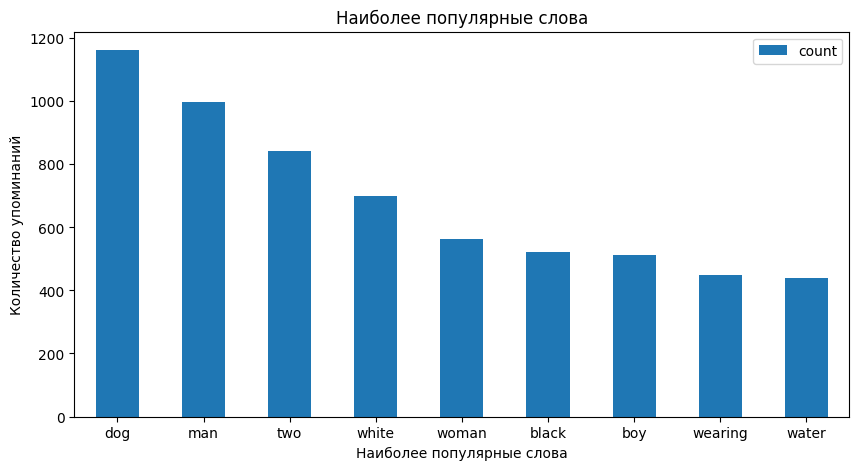

In [23]:
most_common_words_show(most_common_words)

Самое популярное слово - dog

### df_crowd

In [24]:
explore_dataframe(df_crowd)

Shape of dataframe: (47830, 5)


image                     query_id  share_pos  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2        1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2        0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2        0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2        0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2        0.0   

   count_pos  count_neg  
0          3          0  
1          0          3  
2          0          3  
3          0          3  
4          0          3

Info of dataframe: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   image      47830 non-null  object 
 1   query_id   47830 non-null  object 
 2   share_pos  47830 non-null  float64
 3   count_pos  47830 non-null  int64  
 4   count_neg  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB
Summary statistics of dataframe: 
           share_pos     count_pos     count_neg
count  47830.000000  47830.000000  47830.000000
mean       0.068786      0.208488      2.820155
std        0.207532      0.628898      0.656676
min        0.000000      0.000000      0.000000
25%        0.000000      0.000000      3.000000
50%        0.000000      0.000000      3.000000
75%        0.000000      0.000000      3.000000
max        1.000000      5.000000      6.000000
Missing values in dataframe: 
 image        0
query_id     0
s

Датасет содержит 47830 строк и 5 столбцов, дубликатов и пропусков данных нет. Выведем на экран любые 10 изображений

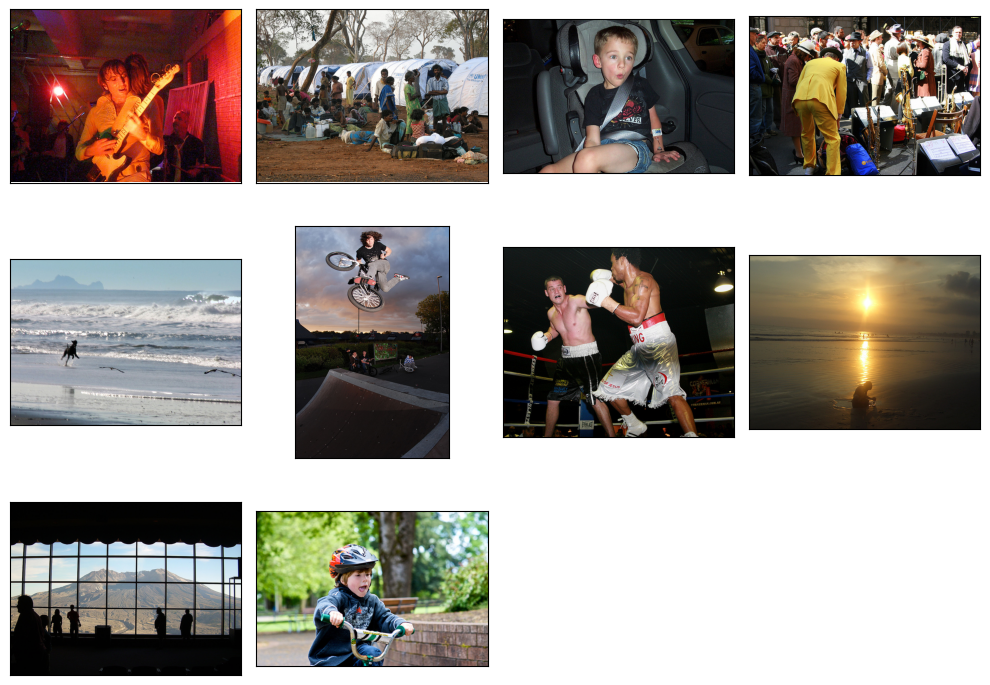

In [ ]:
# выводим 10 изображений
fig = plt.figure(figsize=(10,10))
sample_images = list(df_crowd['image'].sample(10))
for i in range(10):
    fig.add_subplot(4, 4, i+1)
    # задаем изображения
    image = Image.open(Path(PATH, 'train_images', sample_images[i]))
    plt.imshow(image)
    # задаем подписи 
    #plt.title(target[i])
    # для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Посмотрим на соотношение позитивных и негативных ответов на диаграмме. Если доля share_pos > 0.6 - оценим, как 1, если меньше, приравняем ответ к 0

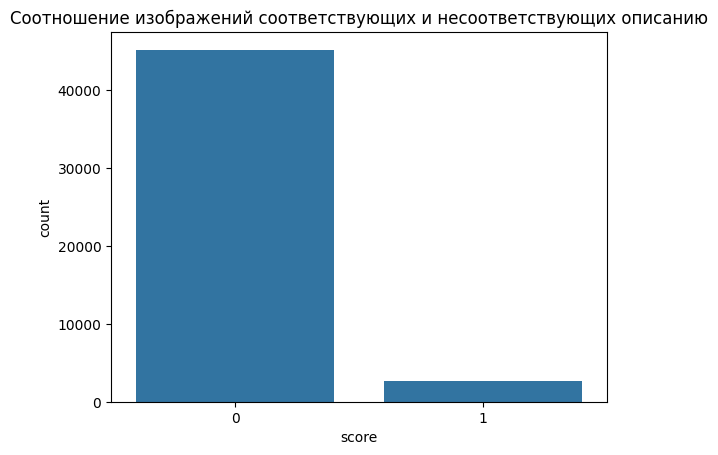

In [26]:
row_copy = df_crowd.copy()

row_copy['score'] = row_copy['share_pos'].apply(lambda x: 1 if x>0.6 else 0)

sns.countplot(data=row_copy, x='score')
plt.title(f'Соотношение изображений соответствующих и несоответcтвующих описанию')
plt.show();

Мы видим, что доля изображений, не соответствующих описанию, намного выше, чем соответствующих.

### df_expert

In [27]:
explore_dataframe(df_expert)

Shape of dataframe: (5822, 5)


image                     query_id  first  second  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2      1       1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2      1       1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2      1       1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2      1       2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2      1       1   

   third  
0      1  
1      2  
2      2  
3      2  
4      2

Info of dataframe: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   first     5822 non-null   int64 
 3   second    5822 non-null   int64 
 4   third     5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB
Summary statistics of dataframe: 
              first       second        third
count  5822.000000  5822.000000  5822.000000
mean      1.436620     1.624356     1.881999
std       0.787084     0.856222     0.904087
min       1.000000     1.000000     1.000000
25%       1.000000     1.000000     1.000000
50%       1.000000     1.000000     2.000000
75%       2.000000     2.000000     2.000000
max       4.000000     4.000000     4.000000
Missing values in dataframe: 
 image       0
query_id    0
first       0
second      0
third       0
dtype: int64
D

Датафрейм состоит из 5822 строк и 5 столбцов. Дубликатов данных нет, пропущенных значений нет. Посмотрим на распределение средних отметок экспертов

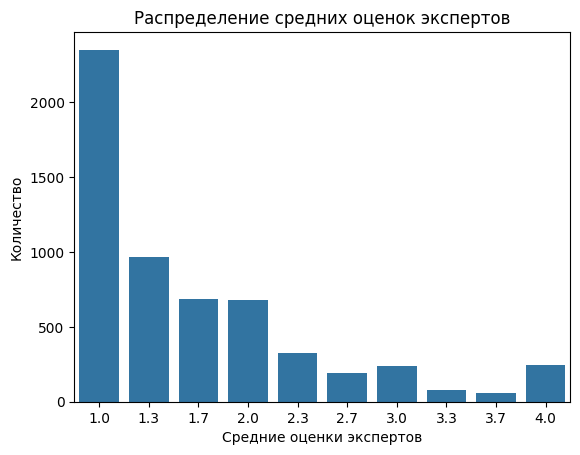

In [28]:
mean_score = ((df_expert['first'] + df_expert['second'] + df_expert['third']) / 3).round(1).value_counts()

sns.barplot(data = mean_score)
plt.title('Распределение средних оценок экспертов')
plt.xlabel('Средние оценки экспертов')
plt.ylabel('Количество');

Мы видим, что эксперты оценили большую часть изображений на 1, что говорит о полном несоответствии изображений описанию

### df_queries

In [29]:
explore_dataframe(df_queries)

Shape of dataframe: (500, 3)


query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

Info of dataframe: 

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB
Summary statistics of dataframe: 
                            query_id  \
count                           500   
unique                          500   
top     1177994172_10d143cb8d.jpg#0   
freq                              1   

                                               query_text  \
count                                                 500   
unique                                                500   
top     Two blonde boys , one in a camouflage shirt an...   
freq                                                    1   

                            image  
count                         500  
unique                        

В датасете содержится 500 изображений и описаний к ним. Дубликаты и пропуски данных отсутствуют, в датасете 100 уникальных изображений и 500 уникальных описаний. Также отмечу, что порядок столбцов в тестовом наборе отличается от тренировочного. Найдем наиболее часто встречающиеся слова в описаниях

In [30]:
#mcw = most_common_words(df_queries["query_text"])
#most_common_words = pd.DataFrame(most_common_words(df_queries["query_text"]), columns=['word','count']).reset_index()

In [31]:
count = Counter()
for line in df_queries['query_text']:
    line = re.sub('[^a-zA-Z]', ' ', line).lower()
    words = [w for w in line.split(" ") if w not in (stops)]
    count.update(words)

most_common = pd.DataFrame(count.most_common(10), columns=['word','count']).reset_index()

Почему-то вызов этой же функции, которая работала в df_train, вызвала ошибку 'DataFrame' object is not callable, поэтому пришлось отправить так

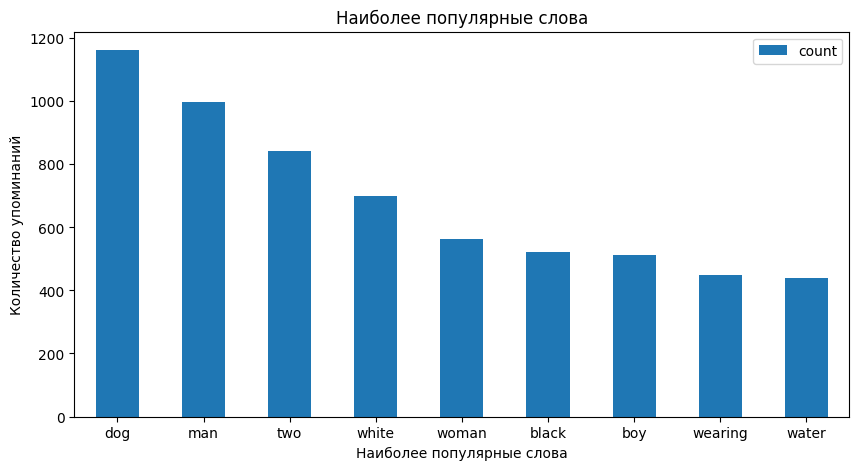

In [32]:
most_common_words_show(most_common)

Здесь набор 10 самых часто встречающихся слов такой же, как и в тренировочной выборке.

### Проведем общую аналитику

Сравним количество описаний фотографий, оценок, и самих фото. Проверим, есть ли утечка данных

In [33]:
# выводим количество уникальных фото разных наборов
print('Количество уникальных фото в тренировочной выборке:', df_train['image'].nunique())
print('Количество уникальных фото на тесте:', df_queries['image'].nunique())

Количество уникальных фото в тренировочной выборке: 1000
Количество уникальных фото на тесте: 100


In [34]:
# выводим количество уникальных описаний разных наборов
print('Количество уникальных описаний в тренировочной выборке:', df_train['query_text'].nunique())
print('Количество уникальных описаний на тесте:', df_queries['query_text'].nunique())

Количество уникальных описаний в тренировочной выборке: 977
Количество уникальных описаний на тесте: 500


In [35]:
# выводим количество уникальных пар фото-текст разных оценщиков
print('Количество уникальных сочетаний фото-текст, оцененных экспертами:', df_expert.shape[0])
print('Количество уникальных сочетаний фото-текст, оцененных людьми:', df_crowd.shape[0])

Количество уникальных сочетаний фото-текст, оцененных экспертами: 5822
Количество уникальных сочетаний фото-текст, оцененных людьми: 47830


In [36]:
print('Количество уникальных текстовых описаний которые есть в обоих наборах:', 
                  len(set(df_train['query_text']) & set(df_queries['query_text'])))

Количество уникальных текстовых описаний которые есть в обоих наборах: 0


In [37]:
print('Количество уникальных изображений которые есть в обоих наборах:', 
                  len(set(df_train['image']) & set(df_queries['image'])))

Количество уникальных изображений которые есть в обоих наборах: 0


### Агрегация оценок

Проведём голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Если 3 оценки будут разные - пара изображение-текст будет исключена из датасета

In [38]:
df_expert['expert_score'] = df_expert.apply( lambda x: voting(x['first'], x['second'], x['third']), axis=1)

In [39]:
# Применим линейное преобразование к столбцу 'expert_score' с оценками в диапазоне [1, 4] -> [0, 1]
df_expert['expert_score'] = (df_expert['expert_score'] - 1) / 3.0

df_expert['expert_score'] = round(df_expert['expert_score'], 2)

In [40]:
df_expert = df_expert.dropna(subset=['expert_score'])

Объединим экспертные и краудсорсинговые оценки, взяв за основу экспертные мнения

In [41]:
# создаем объединенный датафрейм с оценками
df_scores = pd.merge(df_expert, df_crowd, how='left', on=['image', 'query_id'])
df_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5696 entries, 0 to 5695
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image         5696 non-null   object 
 1   query_id      5696 non-null   object 
 2   first         5696 non-null   int64  
 3   second        5696 non-null   int64  
 4   third         5696 non-null   int64  
 5   expert_score  5696 non-null   float64
 6   share_pos     2258 non-null   float64
 7   count_pos     2258 non-null   float64
 8   count_neg     2258 non-null   float64
dtypes: float64(4), int64(3), object(2)
memory usage: 400.6+ KB


В датасете всего 2258 пар изображение-описание, в которых присутствуют обе оценки. Проведем агрегацию оценок

In [42]:
df_scores = df_scores.apply(score_aggregate, axis=1)

In [43]:
df_scores.head()

image                     query_id  first  second  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2      1       1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2      1       1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2      1       1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2      1       2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2      1       1   

   third  expert_score  share_pos  count_pos  count_neg  score  
0      1          0.00        0.0        0.0        3.0   0.00  
1      2          0.00        0.0        0.0        3.0   0.00  
2      2          0.00        NaN        NaN        NaN   0.00  
3      2          0.33        NaN        NaN        NaN   0.33  
4      2          0.00        NaN        NaN        NaN   0.00

In [44]:
# объединяем датафреймы: с оценками и обучающий  
df_train = pd.merge(df_train, 
                    df_scores[['image', 'query_id', 'score']], 
                    how='outer', on=['image', 'query_id'])

In [45]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       5822 non-null   object 
 1   query_id    5822 non-null   object 
 2   query_text  5822 non-null   object 
 3   score       5696 non-null   float64
dtypes: float64(1), object(3)
memory usage: 182.1+ KB


Удалим получившиеся пропуски

In [46]:
df_train = df_train.dropna(subset='score').reset_index(drop=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5696 entries, 0 to 5695
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       5696 non-null   object 
 1   query_id    5696 non-null   object 
 2   query_text  5696 non-null   object 
 3   score       5696 non-null   float64
dtypes: float64(1), object(3)
memory usage: 178.1+ KB


### Вывод по этапу исследовательского анализа данных

Загрузили и исследовали данные.
<br>В нашем распоряжении 1000 изображений для обучения и 100 для теста, предобработанные файлы с парами изображение-описание и оценки соответствия — 5822 шт.
<br>Пересечений между наборами данных для обучения и теста нет.
<br>Большинство оценок — о несоответствии описания изображению, что может сказаться на качестве обучаемой модели.
<br>Агрегировали и объединили экспертные и краудсорсинговые оценки и добавили в обучающий набор.

## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

Возьмем всевозможные слова, которые могут обозначать детей и подростков до 16 лет и добавим их в словарь

In [47]:
BLOCK = ['teenage',
         'teenager',
         'teenagers',
         'baby',
         'babe',
         'girl',
         'girls',
         'boy',
         'boys',
         'child', 
         'kid', 
         'kids',
         'youngster',
         'youth',
         'young'
         ]

In [48]:
lemmatizer = WordNetLemmatizer()

df_train['lemm_query'] = df_train['query_text'].apply(lemmatize_text)

In [49]:
df_train.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2   

                                          query_text  score  \
0  A young child is wearing blue goggles and sitt...   0.00   
1  A girl wearing a yellow shirt and sunglasses s...   0.00   
2    A man sleeps under a blanket on a city street .   0.00   
3  A woman plays with long red ribbons in an empt...   0.33   
4         Chinese market street in the winter time .   0.00   

                                          lemm_query  
0  [a, young, child, is, wearing, blue, goggles, ...  
1  [a, girl, wearing, a, yellow, shirt, and, sung...  
2  [a, man, sleep, under, a, blanket, on, a, city...  
3  [a, woman, play, with, long, red, ribbon, in, ...  
4   [chinese, market, street, in, the, winter, time]

Отметим строки, которые подлежат удалению, исходя из описания данных

In [50]:
df_train = df_train.apply(block, axis=1)

df_train.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2   

                                          query_text  score  \
0  A young child is wearing blue goggles and sitt...   0.00   
1  A girl wearing a yellow shirt and sunglasses s...   0.00   
2    A man sleeps under a blanket on a city street .   0.00   
3  A woman plays with long red ribbons in an empt...   0.33   
4         Chinese market street in the winter time .   0.00   

                                          lemm_query  to_block  
0  [a, young, child, is, wearing, blue, goggles, ...         1  
1  [a, girl, wearing, a, yellow, shirt, and, sung...         1  
2  [a, man, sleep, under, a, blanket, on, a, city...         0  
3  [a, woman, play, with, long, red, ribbon, in, ...         0  
4   [chinese, market, street, in, the, winter, time]         0

Посмотрим, сколько изображений подлежат блокировке

In [51]:
# считаем уникальные заблокированные тексты
bad_texts = df_train.drop_duplicates(subset=['lemm_query'])

# выводим количество уникальных изображений
print('Всего уникальных изображений, подлежащих блокировке:', bad_texts['to_block'].sum())

Всего уникальных изображений, подлежащих блокировке: 300


Удалим такие изображения из набора данных

In [52]:
# создаем список "плохих" изображений 
bad_images = list(set(df_train[df_train['to_block'] == 1]['query_id'])) 
bad_images = [i[:-2] for i in bad_images] 
# считаем количество
print('Всего "плохих" изображений:', len(df_train.query('image in @bad_images'))) 

Всего "плохих" изображений: 1752


In [53]:
# удаляем ненужные строки
df_train.drop(df_train.query('image in @bad_images').index, inplace=True)

# удаляем ненужный столбец
df_train.drop(columns=['to_block', 'lemm_query'], inplace=True)
# сбрасываем индекс
df_train.reset_index(inplace=True, drop=True)

In [54]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3944 entries, 0 to 3943
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       3944 non-null   object 
 1   query_id    3944 non-null   object 
 2   query_text  3944 non-null   object 
 3   score       3944 non-null   float64
dtypes: float64(1), object(3)
memory usage: 123.4+ KB


In [55]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3944 entries, 0 to 3943
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       3944 non-null   object 
 1   query_id    3944 non-null   object 
 2   query_text  3944 non-null   object 
 3   score       3944 non-null   float64
dtypes: float64(1), object(3)
memory usage: 123.4+ KB


Проверили данные и исключили из обучения все описания и изображения, содержащие запрещённую информацию.
В итоговом датафрейме осталось 3944 записей.
Перейдём к векторизации изображений.

## Векторизация изображений
Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

Выполним векторизацию изображений с использованием модели ResNet50

In [56]:
# Создаем генератор данных для обучения модели
train_datagen = ImageDataGenerator(rescale=1./255)#, horizontal_flip=True)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df_train,
        directory=Path(TRAIN_IMAGES_PATH),
        x_col='image',
        y_col='score',
        target_size=(224, 224),
        batch_size=16,
        class_mode='input',
        seed=12345)

# Генерируем и отображаем изображения и их оценки
features, target = next(train_gen_flow)

Found 3944 validated image filenames.


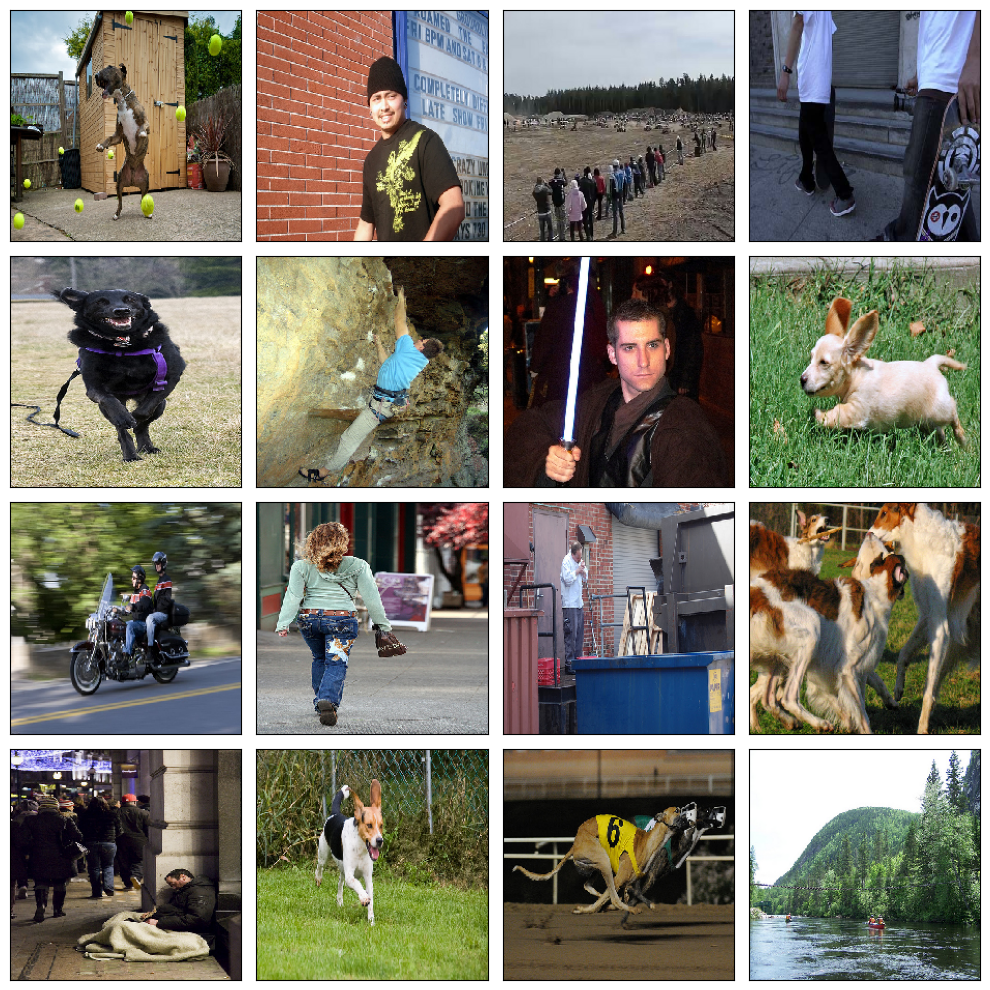

In [ ]:
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.show()

In [58]:
# Создадим модель для векторизации изображений
image_model = create_model()

# Выполним векторизацию изображений с использованием созданной модели и генератора данных
image_embeddings = image_vectorization(image_model, train_gen_flow)

# Выведем размерность полученных векторизованных представлений
image_embeddings.shape

247/247 ━━━━━━━━━━━━━━━━━━━━ 292s 1s/step


(3944, 2048)

Выполнили векторизацию изображений. Получился вектор размера 3944, 2048

## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.

In [59]:
# загружаем модель и токенизатор BERT
bert = transformers.BertModel.from_pretrained('bert-base-uncased')
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

In [60]:
text = df_train['query_text']

# токенизируем каждый текст
tokenized = df_train['query_text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))#, max_length=128))#, truncation=True))
   
# ищем максимальную длину векторов 
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)  
# уравниваем длину векторов       
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

# создаем маску для важных токенов 
attention_mask = np.where(padded != 0, 1, 0)

In [61]:
text_embeddings = vectorization_text(text)#np.concatenate(embeddings)  

  0%|          | 0/40 [00:00<?, ?it/s]

In [62]:
text_embeddings.shape

(3944, 768)

Получили векторизованные тексты для обучения. Размерность признаков: (3944, 768).

## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [63]:
# Объединим векторные представления изображений и текста в один признаковый массив
features = np.concatenate((image_embeddings, text_embeddings), axis=1)

# Получим целевую переменную
target = np.array(df_train['score'])

# Выведем размерности полученных массивов
print("Размерность массива признаков:", features.shape)
print("Размерность целевой переменной:", target.shape)

Размерность массива признаков: (3944, 2816)
Размерность целевой переменной: (3944,)


Успешно объединили векторы изображений и текстов с целевой переменной. Размерность массива признаков: (3944, 2816).
Размерность целевой переменной: (3944,).

## 6  6. Обучение модели предсказания соответствия¶
Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки. Для того чтобы учесть изображения при разбиении, можно воспользоваться классом GroupShuffleSplit из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]


Для обучения будем использовать модели: LinearRegression, RandomForestRegression, CatBoostRegression и NeuralNet. Но сначала разделим датасет на обучающую и валидационную выборки

In [64]:
# запускаем класс разделителя
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=RANDOM_STATE)

# получаем метки обучающей и валидационной выборок
train_indices, val_indices = next(gss.split(X=features, y=target, groups=df_train['image']))

In [65]:
X_train, X_val = features[train_indices], features[val_indices]

In [66]:
y_train, y_val = target[train_indices], target[val_indices]

Масштабируем признаки с помощью StandardScaler

In [67]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

In [68]:
# проверяем итоговый размер признаков и целей
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(2761, 2816)
(2761,)
(1183, 2816)
(1183,)


In [69]:
# Обучим модель линейной регрессии
model_lr = LinearRegression().fit(X_train, y_train)

# Получим прогнозы
predictions = model_lr.predict(X_val)

# Вычислим и выведем RMSE
rmse_lr = mean_squared_error(y_val, predictions, squared=False)
print(f'RMSE для модели линейной регрессии: {rmse_lr:.4f}')

RMSE для модели линейной регрессии: 288.8727


In [70]:
model_cbr = CatBoostRegressor(random_state=RANDOM_STATE, #iterations=1000,
                            #task_type='GPU',
                            #devices='0:1',
                            n_estimators=50,
                            verbose=False).fit(X_train, y_train)

# Получим прогнозы
predictions = model_cbr.predict(X_val)

# Вычислим и выведем RMSE
rmse_cbr = mean_squared_error(y_val, predictions, squared=False)
print(f'RMSE для модели CatBoostRegressor: {rmse_cbr:.4f}')

RMSE для модели CatBoostRegressor: 0.2785


In [71]:
model_rfr = RandomForestRegressor(random_state=RANDOM_STATE, n_estimators=8, max_depth=16).fit(X_train, y_train)
predictions = model_rfr.predict(X_val)
rmse_rfr = mean_squared_error(y_val, predictions, squared=False)
print(f'RMSE для модели RandomForestRegression : {rmse_rfr:.4f}')

RMSE для модели RandomForestRegression : 0.2774


In [72]:
# создаем тензоры для обучения нейросети
X_train = torch.FloatTensor(X_train)
X_val = torch.FloatTensor(X_val)
y_train = torch.FloatTensor(y_train)
y_val = torch.FloatTensor(y_val)

In [73]:
# задаем количество эпох, нейронов в слоях и долю выключаемых нейронов
num_epochs = 100
dropout = 0.2
n_in_neurons = X_train.shape[1]

n_hidden_neurons_1 = 300
n_hidden_neurons_2 = 200
n_hidden_neurons_3 = 100
n_out_neurons = 1 

# задаем скорость обучения
learning_rate = 1e-5 # 0.001 1e-3

#  задаем функцию потерь 
loss = nn.MSELoss() 

In [74]:
model, optimizer, loss = net_init(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_out_neurons, p_dropout=dropout)
print(model)

Sequential(
  (0): Linear(in_features=2816, out_features=300, bias=True)
  (1): Dropout(p=0.2, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=300, out_features=200, bias=True)
  (4): Dropout(p=0.2, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=200, out_features=100, bias=True)
  (7): Dropout(p=0.2, inplace=False)
  (8): ReLU()
  (9): Linear(in_features=100, out_features=1, bias=True)
)


In [75]:
prediction, loss, model = new_net_training(num_epochs=200, batch_size=40)

Лучшая метрика RMSE равна 0.27403802


Соберем все результаты в одну таблицу

In [76]:
pd.DataFrame({'Модель': ['LinearRegression','RandomForestRegression','CatboostRegressor', 'NNet'],
              'RMSE на тренир. выб': [rmse_lr, rmse_rfr, rmse_cbr, loss]
             })

Модель  RMSE на тренир. выб
0        LinearRegression           288.872679
1  RandomForestRegression             0.277442
2       CatboostRegressor             0.278494
3                    NNet             0.274038

Разбили датасет на обучающую и валидационную выборки без дублирования и утечки данных. Выбрали модели: LinearRegression, RandomForestRegression, CatBoostRegressor, NNet. Выбрали метрику — RMSE. Обучили разные модели.

<br>Хуже всех справилась LinearRegression - метрика 288,9. Лучшую метрику RMSE валидационной выборки показала NeuralNetwork — 0.274. Перейдем к тестированию лучшей модели

### Вывод
<br>Разбили датасет на обучающую и валидационную выборки без дублирования и утечки данных. Выбрали модели: LinearRegression, RandomForestRegression, CatBoostRegressor, NNet. Выбрали метрику — RMSE. Обучили разные модели.

<br>Хуже всех справилась LinearRegression - метрика 288,9. Лучшую метрику RMSE валидационной выборки показала NeuralNetwork — 0.274. Перейдем к тестированию лучшей модели

##  7. Тестирование модели
Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки test_images, выберите случайные 10 запросов из файла test_queries.csv и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

In [77]:
# Создаем генератор данных для обучения модели
test_datagen = ImageDataGenerator(rescale=1./255)#, horizontal_flip=True)

test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=df_images,
        directory=Path(TEST_IMAGES_PATH),
        x_col='image',
        y_col='score',
        target_size=(224, 224),
        batch_size=16,
        class_mode='input',
        seed=12345)

Found 100 validated image filenames.


In [78]:
# Выполним векторизацию изображений с использованием созданной модели и генератора данных
image_embeddings_test = image_vectorization(image_model, test_gen_flow)
image_embeddings_test.shape

7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step


(100, 2048)

In [79]:
text = df_queries['query_text']

# токенизируем каждый текст
tokenized = text.apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

  0%|          | 0/40 [00:00<?, ?it/s]


-------------------- A large bird spreading his wings in flight over a body of water . --------------------



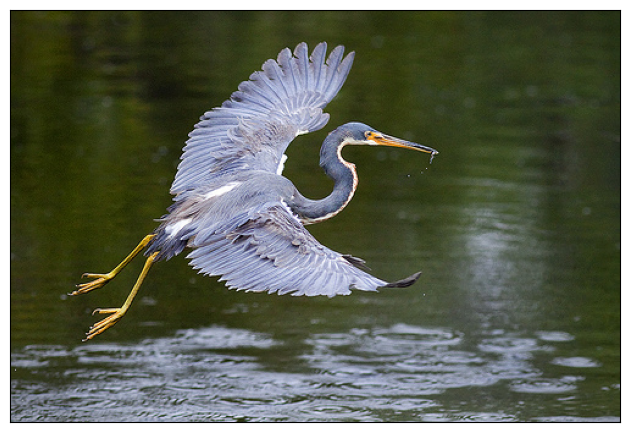

  0%|          | 0/40 [00:00<?, ?it/s]


-------------------- A watercraft speeds through the water . --------------------



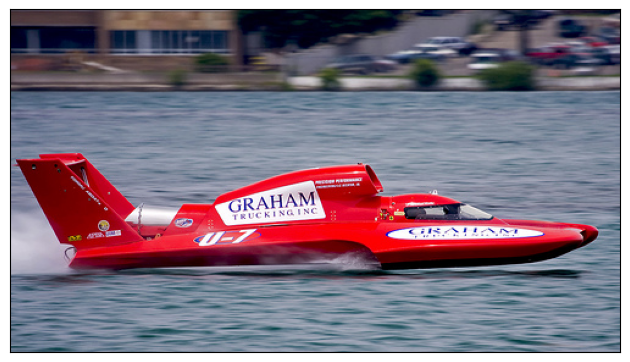

---------- Two young girls on a playground . ----------

This image is unavailable in your country in compliance with local laws.

---------- A boy wearing blue shorts is bouncing a basketball in front of the net . ----------

This image is unavailable in your country in compliance with local laws.



  0%|          | 0/40 [00:00<?, ?it/s]


-------------------- A dog is jumping into a pool for a swim competition --------------------



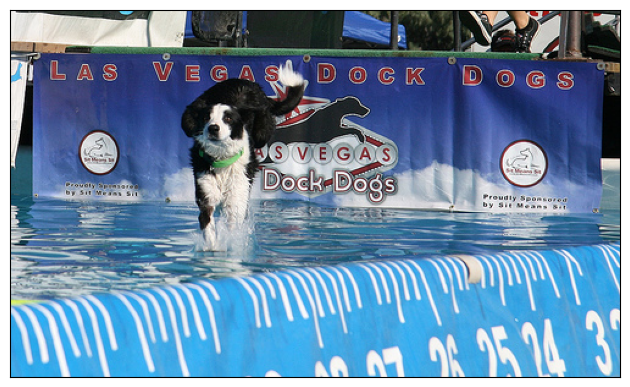

  0%|          | 0/40 [00:00<?, ?it/s]


-------------------- a tan dog wearing a multicolored color running on the beach --------------------



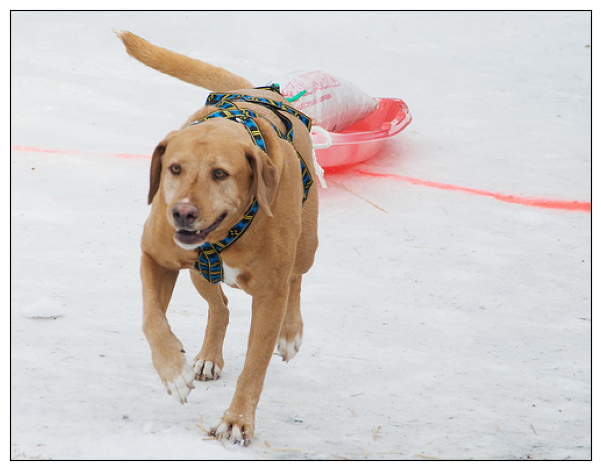

  0%|          | 0/40 [00:00<?, ?it/s]


-------------------- One person in a crowd of people , wearing a blue wig --------------------



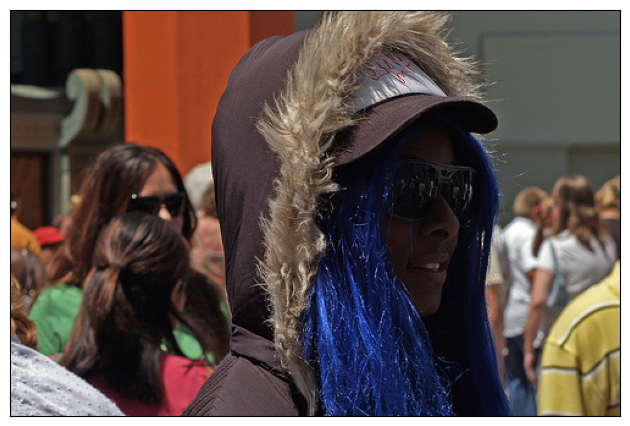

  0%|          | 0/40 [00:00<?, ?it/s]


-------------------- Two dogs are wrestling in a field . --------------------



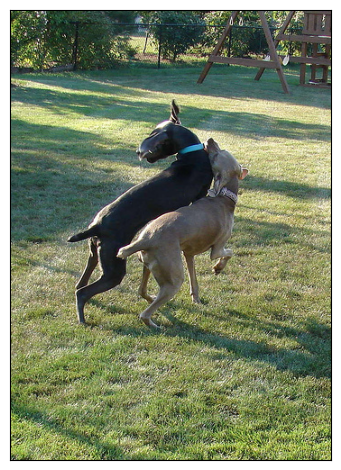

---------- a large group of young people all dressed in white tops and green bottoms ----------

This image is unavailable in your country in compliance with local laws.

---------- Two girls in pink are playing on yellow playground bars . ----------

This image is unavailable in your country in compliance with local laws.



In [80]:
# Выбираем 10 случайных фраз из тестовой выборки и выполняем поиск подходящих изображений
test_phrases = list(text.sample(10))
for phrase in test_phrases:
    check(phrase)

Протестировали лучшую модель — NeuralNetwork. Получили эмбеддинги для тестовых изображений и описаний.
Сформировали 10 случайных описаний и нашли изображения, наиболее подходящие под каждое описание.
На примере 10 случайных описаний модель находит под каждое подходящее изображение. Если в описании содержится слово из блок-списка, на экран выводится сообщение: This image is unavailable in your country in compliance with local laws. 

## Общий вывод по проекту

В рамках проекта мы создали и протестировали демонстрационную версию для системы поиска изображений по описанию.
<br>В ходе работы над проектом мы:
<br>Загрузили данные и провели их исследовательский анализ.
<br>Проверили и объединили оценки экспертов и краудсорсеров.
<br>Исключили из датасета объекты, которые выходят за рамки юридических ограничений.
<br>Векторизовали изображения с помощью ResNet50 и текстовые описания — с Bert.
<br>Объединили векторы изображений и текстов.
<br>Разбили данные на обучающую и валидационную выборки.
<br>Выбрали модели и метрику оценки качества их работы.
<br>Обучили модели и выбрали лучшую.
<br>Протестировали отобранную модель с помощью функции, которая по текстовому описанию возвращает изображение с максимальным значением метрики.
<br>Протестируйте работу модели на нескольких текстовых запросах.
<br>Сформулировали и оформили промежуточный и общий выводы.

Теперь система готова к использованию для сортировки изображений на основе текстовых запросов